## Overview
### Two Tower Architecture
This model is based on the two-tower architecture
The two towers are used to learn representations of both the user and the item. The two-tower model is based on queries and the candidate they both shared a low-dimensional vector space. In our case, a query is customer and its transactions features and the candidate is the articles.

I will try to use mlflow to keep track of experiments (and improve myself with this tool).



![Alt text](https://miro.medium.com/v2/resize:fit:420/1*JbK2gjfLC4IFoM6AVWLaUQ.png)

![Alt text](https://miro.medium.com/v2/resize:fit:420/format:webp/0*aJHT3_bGIvERfhaY)

[image source](https://medium.com/smartnews-inc/user-behavior-sequence-for-items-recommendation-in-smartnews-ads-2376622f6192)



Source: 
- https://medium.com/smartnews-inc/user-behavior-sequence-for-items-recommendation-in-smartnews-ads-2376622f6192
- https://cloud.google.com/blog/products/ai-machine-learning/scaling-deep-retrieval-tensorflow-two-towers-architecture?hl=en

In [1]:
import pandas as pd
import numpy as np
import preprocessing
from sklearn.model_selection import train_test_split
import random
import matplotlib.pyplot as plt
from tqdm import tqdm

from typing import Dict, Tuple, List

import torch
from torch import nn
import torch.nn.functional as F
from torch.utils.data import Dataset, DataLoader

In [2]:
seed = 2024


def set_seed(seed: int):
    random.seed(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)
    torch.cuda.manual_seed(seed)
    torch.backends.cudnn.deterministic = True


set_seed(seed)

## Reading data and feature selections

In [3]:
articles_df = pd.read_csv("data/articles.csv", encoding="utf-8")
print("Shape before: ", articles_df.shape)
articles_df = preprocessing.preprocess_articles(articles_df)
print("Shape after: ", articles_df.shape)

Shape before:  (105542, 25)
Shape after:  (105542, 24)


In [4]:
customers_df = pd.read_csv("data/customers.csv", encoding="utf-8")
print("Shape before: ", customers_df.shape)
customers_df = preprocessing.preprocess_customers(customers_df)
print("Shape after: ", customers_df.shape)

Shape before:  (1371980, 7)
Shape after:  (1356119, 5)


In [5]:
transaction_df = pd.read_csv("data/transactions_train.csv", encoding="utf-8")
print("Shape before: ", transaction_df.shape)
transaction_df = preprocessing.preprocess_transactions(transaction_df)
print("Shape after: ", transaction_df.shape)

Shape before:  (31788324, 5)
Shape after:  (31788324, 11)


In [6]:
# join the three data sources to make the data compatible with out retrieval model.
df = pd.merge(
    pd.merge(
        transaction_df[["article_id", "customer_id", "t_dat", "price", "month_sin", "month_cos"]], articles_df[["article_id", "garment_group_name", "index_group_name"]], on="article_id", how="inner"
    ),
    customers_df[["customer_id", "age", "club_member_status", "age_group"]],
    on="customer_id",
    how="inner",
)

In [7]:
df.head(2)

,article_id,customer_id,t_dat,price,month_sin,month_cos,garment_group_name,index_group_name,age,club_member_status,age_group
0,663713001,000058a12d5b43e67d225668fa1f8d618c13dc232df0ca...,2018-09-20,0.050831,-0.866025,-0.5,"Under-, Nightwear",Ladieswear,24.0,ACTIVE,19-25
1,663713001,000058a12d5b43e67d225668fa1f8d618c13dc232df0ca...,2018-09-24,0.050831,-0.866025,-0.5,"Under-, Nightwear",Ladieswear,24.0,ACTIVE,19-25


In [8]:
df.shape

(31648066, 11)

## Train/Validate/Test split and Tensors

In [9]:
train_df, val_df = train_test_split(df, test_size=0.1, random_state=seed)

In [10]:
train_df.isnull().sum()

article_id            0
customer_id           0
t_dat                 0
price                 0
month_sin             0
month_cos             0
garment_group_name    0
index_group_name      0
age                   0
club_member_status    0
age_group             0
dtype: int64

In [11]:
print("Training shape: ", train_df.shape)
print("Validation shape: ", val_df.shape)

Training shape:  (28483259, 11)
Validation shape:  (3164807, 11)


In [12]:
class CustomDataset(Dataset):
    def __init__(self, df):
        self.data = {col: torch.tensor(df[col].values) if pd.api.types.is_numeric_dtype(df[col]) else df[col].values for col in df.columns}

    def __len__(self):
        return len(next(iter(self.data.values())))

    def __getitem__(self, idx):
        return {key: value[idx] for key, value in self.data.items()}

In [13]:
def custom_collate_fn(batch):
    """
    Custom collate function to handle mixed-type datasets

    Args:
        batch (list): List of dictionaries from the dataset

    Returns:
        dict: A dictionary with tensors and arrays properly handled
    """
    # Initialize dictionaries to collect data
    collated_batch = {}

    # Iterate through keys of the first item to get all column names
    for key in batch[0].keys():
        # Collect values for this key
        values = [item[key] for item in batch]

        # Check the type of the first value to determine how to process
        if isinstance(values[0], torch.Tensor):
            # If it's already a tensor, stack them
            collated_batch[key] = torch.stack(values)
        elif isinstance(values[0], np.ndarray):
            # If it's a numpy array, convert to tensor or keep as array
            if values[0].dtype in [np.float32, np.float64, np.int32, np.int64]:
                collated_batch[key] = torch.tensor(values)
            else:
                collated_batch[key] = np.array(values)
        else:
            # For other types (like strings), keep as list or array
            collated_batch[key] = np.array(values)

    return collated_batch

In [14]:
BATCH_SIZE = 2048  # 2048
train_dataset = CustomDataset(train_df)
train_dataset[0:2]

{'article_id': array(['800800004', '770211001'], dtype=object),
 'customer_id': array(['7169c8c204f8e37131bb13f05b31a0786e70d6789fa72af320bf245d7e4ccf74',
        '0c6a37c6008e0740828502652ab3c7120b68d27a26fee734a9dee0f121997924'],
       dtype=object),
 't_dat': array(['2020-02-14T00:00:00.000000000', '2019-06-29T00:00:00.000000000'],
       dtype='datetime64[ns]'),
 'price': tensor([0.0169, 0.0190], dtype=torch.float64),
 'month_sin': tensor([0.5000, 0.5000], dtype=torch.float64),
 'month_cos': tensor([ 0.8660, -0.8660], dtype=torch.float64),
 'garment_group_name': array(['Jersey Fancy', 'Dresses Ladies'], dtype=object),
 'index_group_name': array(['Ladieswear', 'Ladieswear'], dtype=object),
 'age': tensor([38., 23.], dtype=torch.float64),
 'club_member_status': array(['ACTIVE', 'ACTIVE'], dtype=object),
 'age_group': ['36-45', '19-25']
 Categories (8, object): ['0-18' < '19-25' < '26-35' < '36-45' < '46-55' < '56-65' < '66-80' < '80+']}

In [15]:
user_id_list = df["customer_id"].unique().tolist()
item_id_list = df["article_id"].unique().tolist()

In [16]:
garment_group_list = df["garment_group_name"].unique().tolist()
index_group_list = df["index_group_name"].unique().tolist()

In [17]:
print(f"Number of garment group: {len(garment_group_list):,}")
print(f"Number of index group: {len(index_group_list):,}")

Number of garment group: 21
Number of index group: 5


In [18]:
print(f"Number of transactions: {len(train_df):,}")
print(f"Number of users: {len(user_id_list):,}")
print(f"Number of items: {len(item_id_list):,}")
print(garment_group_list)

Number of transactions: 28,483,259
Number of users: 1,346,520
Number of items: 104,513
['Under-, Nightwear', 'Blouses', 'Swimwear', 'Knitwear', 'Skirts', 'Jersey Basic', 'Trousers', 'Unknown', 'Socks and Tights', 'Trousers Denim', 'Dressed', 'Outdoor', 'Accessories', 'Jersey Fancy', 'Special Offers', 'Dresses Ladies', 'Shorts', 'Shoes', 'Dresses/Skirts girls', 'Shirts', 'Woven/Jersey/Knitted mix Baby']


## Two Tower Model

- Query model: Generates a query representation given user and transaction features.
- Candidate model: Generates an item representation given item features.

**Both models produce embeddings that live in the same embedding space.**


For the query embedding I will use:
- `customer_id`: ID of the customer.
- `age`: age of the customer at the time of purchase.
- `month_sin`, `month_cos`: time of year the purchase was made.

For the candidate embedding I will use:
- `article_id`: ID of the item.
- `garment_group_name`: type of garment.
- `index_group_name`: menswear/ladieswear etc.





In [19]:
device = "cuda" if torch.cuda.is_available() else "cpu"
print(f"Using {device} device")

Using cpu device


In [20]:
class StringLookup:

    def __init__(self, vocabulary: List[str], mask_token=None):
        self.vocab = {word: idx for idx, word in enumerate(vocabulary)}
        self.vocab["<UNK>"] = len(self.vocab)
        self.mask_token = mask_token

    def __call__(self, inputs: np.ndarray) -> torch.Tensor:
        # Convert string inputs to indices
        indices = [self.vocab.get(x, self.vocab["<UNK>"]) for x in inputs]
        return torch.tensor(indices, dtype=torch.long)

    def __len__(self):
        return len(self.vocab)


class StringEmbedding(nn.Module):
    def __init__(self, user_id_list: List[str], embedding_dimension: int):
        super().__init__()

        # Create the vocabulary space
        self.string_lookup = StringLookup(user_id_list)

        # The real embeddings
        self.embedding = nn.Embedding(num_embeddings=len(self.string_lookup), embedding_dim=embedding_dimension)

    def forward(self, user_ids: torch.Tensor) -> torch.Tensor:
        # Convert user IDs to indices
        return self.embedding(self.string_lookup(user_ids))

In [21]:
class QueryTower(nn.Module):

    def __init__(self, user_id_list: List[str], embedding_dimension: int):
        super().__init__()

        self.user_embedding = StringEmbedding(user_id_list, embedding_dimension)
        self.age_normalization = nn.BatchNorm1d(1)

        self.dense_nn = nn.Sequential(nn.Linear(in_features=embedding_dimension + 3, out_features=embedding_dimension), nn.Dropout(0.2), nn.ReLU(), nn.Linear(embedding_dimension, embedding_dimension))

    def forward(self, inputs: Dict[str, torch.Tensor]) -> torch.Tensor:
        user_embedding = self.user_embedding(inputs["customer_id"])
        normalized_age = self.age_normalization(inputs["age"].float().unsqueeze(1))
        month_sin = inputs["month_sin"].float().unsqueeze(1)
        month_cos = inputs["month_cos"].float().unsqueeze(1)

        concatenated_inputs = torch.cat([user_embedding, normalized_age, month_sin, month_cos], dim=1)

        outputs = self.dense_nn(concatenated_inputs)
        return outputs

In [22]:
QueryTower(user_id_list, 128)(train_dataset[0:2]).shape

torch.Size([2, 128])

The candidate model is very similar to the query model.

it has two categorical features which will be one-hot encode.

In [23]:
class ItemTower(nn.Module):

    def __init__(self, item_id_list: List[str], garment_group_list: List[str], index_group_list: List[str], embedding_dimension: int):
        super().__init__()
        self.item_embedding = StringEmbedding(item_id_list, embedding_dimension)

        # Garment group setup
        self.garment_group_lookup = StringLookup(vocabulary=garment_group_list)
        self.garment_group_size = len(garment_group_list)

        # Index group setup
        self.index_group_lookup = StringLookup(vocabulary=index_group_list)
        self.index_group_size = len(index_group_list)

        input_dim = embedding_dimension + self.garment_group_size + self.index_group_size
        self.dense_nn = nn.Sequential(nn.Linear(input_dim, embedding_dimension), nn.Dropout(0.2), nn.ReLU(), nn.Linear(embedding_dimension, embedding_dimension))

    def forward(self, inputs: Dict[str, torch.Tensor]) -> torch.Tensor:

        # Convert article_id strings to embeddings
        item_embedding = self.item_embedding(inputs["article_id"])

        garment_indices = self.garment_group_lookup(inputs["garment_group_name"])
        garment_one_hot = torch.zeros((garment_indices.size(0), self.garment_group_size), dtype=torch.float)
        garment_one_hot.scatter_(1, garment_indices.unsqueeze(1), 1.0)

        # Convert index group strings to one-hot encodings
        index_indices = self.index_group_lookup(inputs["index_group_name"])
        index_one_hot = torch.zeros((index_indices.size(0), self.index_group_size), dtype=torch.float)
        index_one_hot.scatter_(1, index_indices.unsqueeze(1), 1.0)

        # Concatenate all features
        concatenated = torch.cat([item_embedding, garment_one_hot, index_one_hot], dim=1)

        outputs = self.dense_nn(concatenated)

        return outputs

In [24]:
ItemTower(item_id_list, garment_group_list, index_group_list, 128)(train_dataset[0:2]).shape

torch.Size([2, 128])

In [25]:
# Create dataset of unique items
unique_items_df = df.drop_duplicates("article_id")[["article_id", "garment_group_name", "index_group_name"]]

In [26]:
unique_items_df["article_id"] = unique_items_df["article_id"].astype(np.int64)

In [27]:
unique_items_dataset = CustomDataset(unique_items_df)
unique_items_loader = DataLoader(unique_items_dataset, batch_size=BATCH_SIZE, shuffle=False)

In [28]:
unique_items_dataset[0:2]

{'article_id': tensor([663713001, 541518023]),
 'garment_group_name': array(['Under-, Nightwear', 'Under-, Nightwear'], dtype=object),
 'index_group_name': array(['Ladieswear', 'Ladieswear'], dtype=object)}

In [29]:
class TwoTowerModel(nn.Module):


    def __init__(self, query_tower: nn.Module, item_tower: nn.Module):


        super().__init__()
        self.query_tower = query_tower
        self.item_tower = item_tower


    def forward(self, batch: Dict) -> Tuple[torch.Tensor, torch.Tensor]:


        query_embeddings = self.query_tower(batch)


        item_embeddings = self.item_tower(batch)


        # Normalize embeddings


        query_embeddings = F.normalize(query_embeddings, p=2, dim=1)


        item_embeddings = F.normalize(item_embeddings, p=2, dim=1)

        return query_embeddings, item_embeddings

In [30]:
class RetrievalLoss(nn.Module):

    def __init__(self, temperature: float = None):
        super(RetrievalLoss, self).__init__()
        self.temperature = temperature

    def forward(self, query_embeddings, item_embeddings, labels=None):

        # Calculate dot product (similarity scores) between query and candidates
        similarities = torch.matmul(query_embeddings, item_embeddings.t())  # [batch_size, num_items]

        if self.temperature is not None:
            similarities /= self.temperature

        num_queries = similarities.shape[0]
        # num_candidates = similarities.shape[1]

        if labels is None:
            labels = torch.eye(num_queries)  # [batch_size]

        loss_fn = nn.CrossEntropyLoss(reduce="none")

        loss = loss_fn(similarities, labels)
        return loss

In [31]:
def train_model(train_dataloader: DataLoader, val_dataloader: DataLoader, model: TwoTowerModel, learning_rate: float, weight_decay: float, num_epochs: int):
    optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate, weight_decay=weight_decay)
    train_loss_history = []
    val_loss_history = []
    print_every = 1000

    retrieval_loss_fn = RetrievalLoss()
    for epoch in range(num_epochs):
        model.train()
        train_losses = []

        bformat = "{l_bar}{bar}| {n_fmt}/{total_fmt} {rate_fmt}{postfix}"
        with tqdm(total=len(train_dataloader), bar_format=bformat) as pbar:

            for batch_idx, train_batch in enumerate(train_dataloader):

                optimizer.zero_grad()
                query_embeddings, item_embeddings = model(train_batch)
                loss = retrieval_loss_fn(query_embeddings, item_embeddings)
                loss.backward()
                optimizer.step()
                train_losses.append(loss.item())

                pbar.set_description(f"EPOCH: {epoch:02d} ")
                pbar.set_postfix_str(" LOSS: {:.4f} ".format(train_losses[-1]))
                pbar.update()
                mean_train_loss = np.mean(train_losses)

                if batch_idx % print_every == 0:
                    print("Training: Batch {0}/{1}. Avg Loss of {2:.4f}".format(batch_idx + 1, len(train_dataloader), mean_train_loss))

        # Last batch values
        print("Training: Batch {0}/{1}. Avg Loss of {2:.4f}".format(batch_idx + 1, len(train_dataloader), mean_train_loss))

        # Validation
        model.eval()
        val_loss = 0
        with torch.no_grad():
            for batch_idx, val_batch in tqdm(enumerate(val_dataloader), desc="Validation: "):
                query_embeddings, item_embeddings = model(val_batch)
                val_loss += retrieval_loss_fn(query_embeddings, item_embeddings).item()

        print(f"Epoch {epoch+1}/{num_epochs}:")
        mean_train_loss = np.mean(train_losses)
        train_loss_history.append(mean_train_loss)
        val_loss_history.append(val_loss / len(val_dataloader))
        print("Training Loss: {0:.4f}".format(train_loss_history[-1]))
        print("Validation Loss: {0:.4f}".format(val_loss_history[-1]))

        torch.save(model.state_dict(), f"models/training/Epoch_n_{epoch + 1}.pkl")

    return model, train_loss_history, val_loss_history

In [32]:
embedding_dimension = 32
model = TwoTowerModel(
    query_tower=QueryTower(user_id_list, embedding_dimension=embedding_dimension), item_tower=ItemTower(item_id_list, garment_group_list, index_group_list, embedding_dimension=embedding_dimension)
)
model

TwoTowerModel(
  (query_tower): QueryTower(
    (user_embedding): StringEmbedding(
      (embedding): Embedding(1346521, 32)
    )
    (age_normalization): BatchNorm1d(1, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (dense_nn): Sequential(
      (0): Linear(in_features=35, out_features=32, bias=True)
      (1): Dropout(p=0.2, inplace=False)
      (2): ReLU()
      (3): Linear(in_features=32, out_features=32, bias=True)
    )
  )
  (item_tower): ItemTower(
    (item_embedding): StringEmbedding(
      (embedding): Embedding(104514, 32)
    )
    (dense_nn): Sequential(
      (0): Linear(in_features=58, out_features=32, bias=True)
      (1): Dropout(p=0.2, inplace=False)
      (2): ReLU()
      (3): Linear(in_features=32, out_features=32, bias=True)
    )
  )
)

In [33]:
learning_rate = 1e-2
weight_decay = 1e-3
num_epochs = 7

In [34]:
BATCH_SIZE = 2048  # 2048

# Create datasets
train_dataset = CustomDataset(train_df)
val_dataset = CustomDataset(val_df)

# Create DataLoaders
train_loader = DataLoader(train_dataset, batch_size=BATCH_SIZE, shuffle=True, num_workers=0, collate_fn=custom_collate_fn)

val_loader = DataLoader(val_dataset, batch_size=BATCH_SIZE, shuffle=False, num_workers=0, collate_fn=custom_collate_fn)

In [35]:
model, train_loss_history, val_loss_history = train_model(train_loader, val_loader, model, learning_rate, weight_decay, num_epochs)

  0%|          | 0/13908 ?it/se:\Projects\H_M_Personalized_Fashion_Recommendations\venv\lib\site-packages\torch\nn\_reduction.py:51: UserWarning: size_average and reduce args will be deprecated, please use reduction='mean' instead.
  warnings.warn(warning.format(ret))
EPOCH: 00 :   0%|          | 1/13908  4.09s/it,  LOSS: 7.6327 

Training: Batch 1/13908. Avg Loss of 7.6327


EPOCH: 00 :   7%|▋         | 1001/13908  1.90it/s,  LOSS: 7.4058 

Training: Batch 1001/13908. Avg Loss of 7.4932


EPOCH: 00 :  14%|█▍        | 2001/13908  1.66it/s,  LOSS: 7.3867 

Training: Batch 2001/13908. Avg Loss of 7.4414


EPOCH: 00 :  22%|██▏       | 3001/13908  1.84it/s,  LOSS: 7.3843 

Training: Batch 3001/13908. Avg Loss of 7.4213


EPOCH: 00 :  29%|██▉       | 4001/13908  1.75it/s,  LOSS: 7.3767 

Training: Batch 4001/13908. Avg Loss of 7.4108


EPOCH: 00 :  36%|███▌      | 5001/13908  1.70it/s,  LOSS: 7.3749 

Training: Batch 5001/13908. Avg Loss of 7.4044


EPOCH: 00 :  43%|████▎     | 6001/13908  1.66it/s,  LOSS: 7.3966 

Training: Batch 6001/13908. Avg Loss of 7.4000


EPOCH: 00 :  50%|█████     | 7001/13908  1.62it/s,  LOSS: 7.3756 

Training: Batch 7001/13908. Avg Loss of 7.3969


EPOCH: 00 :  58%|█████▊    | 8001/13908  1.72it/s,  LOSS: 7.3943 

Training: Batch 8001/13908. Avg Loss of 7.3945


EPOCH: 00 :  65%|██████▍   | 9001/13908  1.72it/s,  LOSS: 7.3604 

Training: Batch 9001/13908. Avg Loss of 7.3927


EPOCH: 00 :  72%|███████▏  | 10001/13908  1.88it/s,  LOSS: 7.3631 

Training: Batch 10001/13908. Avg Loss of 7.3913


EPOCH: 00 :  79%|███████▉  | 11001/13908  1.83it/s,  LOSS: 7.3580 

Training: Batch 11001/13908. Avg Loss of 7.3901


EPOCH: 00 :  86%|████████▋ | 12001/13908  1.77it/s,  LOSS: 7.3737 

Training: Batch 12001/13908. Avg Loss of 7.3890


EPOCH: 00 :  93%|█████████▎| 13001/13908  1.87it/s,  LOSS: 7.3662 

Training: Batch 13001/13908. Avg Loss of 7.3882


EPOCH: 00 : 100%|██████████| 13908/13908  1.74it/s,  LOSS: 7.2125 


Training: Batch 13908/13908. Avg Loss of 7.3876


Validation: : 1546it [02:53,  8.91it/s]


Epoch 1/7:
Training Loss: 7.3876
Validation Loss: 7.3665


EPOCH: 01 :   0%|          | 1/13908  2.59s/it,  LOSS: 7.3875 

Training: Batch 1/13908. Avg Loss of 7.3875


EPOCH: 01 :   7%|▋         | 1001/13908  1.72it/s,  LOSS: 7.3667 

Training: Batch 1001/13908. Avg Loss of 7.3781


EPOCH: 01 :  14%|█▍        | 2001/13908  1.88it/s,  LOSS: 7.3776 

Training: Batch 2001/13908. Avg Loss of 7.3779


EPOCH: 01 :  22%|██▏       | 3001/13908  1.79it/s,  LOSS: 7.3820 

Training: Batch 3001/13908. Avg Loss of 7.3784


EPOCH: 01 :  29%|██▉       | 4001/13908  1.84it/s,  LOSS: 7.3853 

Training: Batch 4001/13908. Avg Loss of 7.3782


EPOCH: 01 :  36%|███▌      | 5001/13908  1.88it/s,  LOSS: 7.3834 

Training: Batch 5001/13908. Avg Loss of 7.3782


EPOCH: 01 :  43%|████▎     | 6001/13908  1.68it/s,  LOSS: 7.3911 

Training: Batch 6001/13908. Avg Loss of 7.3782


EPOCH: 01 :  50%|█████     | 7001/13908  1.83it/s,  LOSS: 7.3750 

Training: Batch 7001/13908. Avg Loss of 7.3782


EPOCH: 01 :  58%|█████▊    | 8001/13908  1.85it/s,  LOSS: 7.4012 

Training: Batch 8001/13908. Avg Loss of 7.3782


EPOCH: 01 :  65%|██████▍   | 9001/13908  1.88it/s,  LOSS: 7.3723 

Training: Batch 9001/13908. Avg Loss of 7.3782


EPOCH: 01 :  72%|███████▏  | 10001/13908  1.76it/s,  LOSS: 7.3955 

Training: Batch 10001/13908. Avg Loss of 7.3783


EPOCH: 01 :  79%|███████▉  | 11001/13908  1.78it/s,  LOSS: 7.3786 

Training: Batch 11001/13908. Avg Loss of 7.3782


EPOCH: 01 :  86%|████████▋ | 12001/13908  1.82it/s,  LOSS: 7.3780 

Training: Batch 12001/13908. Avg Loss of 7.3782


EPOCH: 01 :  93%|█████████▎| 13001/13908  1.83it/s,  LOSS: 7.3767 

Training: Batch 13001/13908. Avg Loss of 7.3782


EPOCH: 01 : 100%|██████████| 13908/13908  1.80it/s,  LOSS: 7.2274 


Training: Batch 13908/13908. Avg Loss of 7.3783


Validation: : 1546it [02:49,  9.13it/s]


Epoch 2/7:
Training Loss: 7.3783
Validation Loss: 7.3654


EPOCH: 02 :   0%|          | 1/13908  2.68s/it,  LOSS: 7.3502 

Training: Batch 1/13908. Avg Loss of 7.3502


EPOCH: 02 :   7%|▋         | 1001/13908  1.88it/s,  LOSS: 7.3889 

Training: Batch 1001/13908. Avg Loss of 7.3779


EPOCH: 02 :  14%|█▍        | 2001/13908  1.77it/s,  LOSS: 7.3771 

Training: Batch 2001/13908. Avg Loss of 7.3784


EPOCH: 02 :  22%|██▏       | 3001/13908  1.93it/s,  LOSS: 7.3863 

Training: Batch 3001/13908. Avg Loss of 7.3785


EPOCH: 02 :  29%|██▉       | 4001/13908  1.87it/s,  LOSS: 7.3765 

Training: Batch 4001/13908. Avg Loss of 7.3786


EPOCH: 02 :  36%|███▌      | 5001/13908  1.59it/s,  LOSS: 7.4003 

Training: Batch 5001/13908. Avg Loss of 7.3786


EPOCH: 02 :  43%|████▎     | 6001/13908  1.81it/s,  LOSS: 7.3864 

Training: Batch 6001/13908. Avg Loss of 7.3786


EPOCH: 02 :  50%|█████     | 7001/13908  1.78it/s,  LOSS: 7.3618 

Training: Batch 7001/13908. Avg Loss of 7.3787


EPOCH: 02 :  58%|█████▊    | 8001/13908  1.83it/s,  LOSS: 7.3710 

Training: Batch 8001/13908. Avg Loss of 7.3786


EPOCH: 02 :  65%|██████▍   | 9001/13908  1.87it/s,  LOSS: 7.3721 

Training: Batch 9001/13908. Avg Loss of 7.3786


EPOCH: 02 :  72%|███████▏  | 10001/13908  1.91it/s,  LOSS: 7.3826 

Training: Batch 10001/13908. Avg Loss of 7.3786


EPOCH: 02 :  79%|███████▉  | 11001/13908  1.77it/s,  LOSS: 7.3957 

Training: Batch 11001/13908. Avg Loss of 7.3785


EPOCH: 02 :  86%|████████▋ | 12001/13908  1.82it/s,  LOSS: 7.3903 

Training: Batch 12001/13908. Avg Loss of 7.3785


EPOCH: 02 :  93%|█████████▎| 13001/13908  1.89it/s,  LOSS: 7.3931 

Training: Batch 13001/13908. Avg Loss of 7.3785


EPOCH: 02 : 100%|██████████| 13908/13908  1.80it/s,  LOSS: 7.2104 


Training: Batch 13908/13908. Avg Loss of 7.3785


Validation: : 1546it [02:48,  9.16it/s]


Epoch 3/7:
Training Loss: 7.3785
Validation Loss: 7.3689


EPOCH: 03 :   0%|          | 1/13908  2.59s/it,  LOSS: 7.3774 

Training: Batch 1/13908. Avg Loss of 7.3774


EPOCH: 03 :   7%|▋         | 1001/13908  1.78it/s,  LOSS: 7.3834 

Training: Batch 1001/13908. Avg Loss of 7.3789


EPOCH: 03 :  14%|█▍        | 2001/13908  1.90it/s,  LOSS: 7.3612 

Training: Batch 2001/13908. Avg Loss of 7.3787


EPOCH: 03 :  22%|██▏       | 3001/13908  1.81it/s,  LOSS: 7.3773 

Training: Batch 3001/13908. Avg Loss of 7.3788


EPOCH: 03 :  29%|██▉       | 4001/13908  1.60it/s,  LOSS: 7.3877 

Training: Batch 4001/13908. Avg Loss of 7.3788


EPOCH: 03 :  36%|███▌      | 5001/13908  1.85it/s,  LOSS: 7.3767 

Training: Batch 5001/13908. Avg Loss of 7.3789


EPOCH: 03 :  43%|████▎     | 6001/13908  1.79it/s,  LOSS: 7.3709 

Training: Batch 6001/13908. Avg Loss of 7.3786


EPOCH: 03 :  50%|█████     | 7001/13908  1.72it/s,  LOSS: 7.3733 

Training: Batch 7001/13908. Avg Loss of 7.3786


EPOCH: 03 :  58%|█████▊    | 8001/13908  1.78it/s,  LOSS: 7.3936 

Training: Batch 8001/13908. Avg Loss of 7.3787


EPOCH: 03 :  65%|██████▍   | 9001/13908  1.64it/s,  LOSS: 7.3722 

Training: Batch 9001/13908. Avg Loss of 7.3786


EPOCH: 03 :  72%|███████▏  | 10001/13908  1.87it/s,  LOSS: 7.3766 

Training: Batch 10001/13908. Avg Loss of 7.3788


EPOCH: 03 :  79%|███████▉  | 11001/13908  1.82it/s,  LOSS: 7.3971 

Training: Batch 11001/13908. Avg Loss of 7.3787


EPOCH: 03 :  86%|████████▋ | 12001/13908  1.90it/s,  LOSS: 7.3820 

Training: Batch 12001/13908. Avg Loss of 7.3787


EPOCH: 03 :  93%|█████████▎| 13001/13908  1.90it/s,  LOSS: 7.3860 

Training: Batch 13001/13908. Avg Loss of 7.3788


EPOCH: 03 : 100%|██████████| 13908/13908  1.80it/s,  LOSS: 7.2030 


Training: Batch 13908/13908. Avg Loss of 7.3787


Validation: : 1546it [02:51,  9.04it/s]


Epoch 4/7:
Training Loss: 7.3787
Validation Loss: 7.3692


EPOCH: 04 :   0%|          | 1/13908  2.61s/it,  LOSS: 7.3889 

Training: Batch 1/13908. Avg Loss of 7.3889


EPOCH: 04 :   7%|▋         | 1001/13908  1.79it/s,  LOSS: 7.3785 

Training: Batch 1001/13908. Avg Loss of 7.3784


EPOCH: 04 :  14%|█▍        | 2001/13908  1.90it/s,  LOSS: 7.3856 

Training: Batch 2001/13908. Avg Loss of 7.3789


EPOCH: 04 :  22%|██▏       | 3001/13908  1.68it/s,  LOSS: 7.3641 

Training: Batch 3001/13908. Avg Loss of 7.3788


EPOCH: 04 :  29%|██▉       | 4001/13908  1.86it/s,  LOSS: 7.3839 

Training: Batch 4001/13908. Avg Loss of 7.3786


EPOCH: 04 :  36%|███▌      | 5001/13908  1.75it/s,  LOSS: 7.3784 

Training: Batch 5001/13908. Avg Loss of 7.3787


EPOCH: 04 :  43%|████▎     | 6001/13908  1.91it/s,  LOSS: 7.4054 

Training: Batch 6001/13908. Avg Loss of 7.3787


EPOCH: 04 :  50%|█████     | 7001/13908  1.69it/s,  LOSS: 7.3709 

Training: Batch 7001/13908. Avg Loss of 7.3786


EPOCH: 04 :  58%|█████▊    | 8001/13908  1.77it/s,  LOSS: 7.3581 

Training: Batch 8001/13908. Avg Loss of 7.3786


EPOCH: 04 :  65%|██████▍   | 9001/13908  1.85it/s,  LOSS: 7.3804 

Training: Batch 9001/13908. Avg Loss of 7.3786


EPOCH: 04 :  72%|███████▏  | 10001/13908  1.80it/s,  LOSS: 7.3894 

Training: Batch 10001/13908. Avg Loss of 7.3786


EPOCH: 04 :  79%|███████▉  | 11001/13908  1.92it/s,  LOSS: 7.3769 

Training: Batch 11001/13908. Avg Loss of 7.3786


EPOCH: 04 :  86%|████████▋ | 12001/13908  1.87it/s,  LOSS: 7.3763 

Training: Batch 12001/13908. Avg Loss of 7.3786


EPOCH: 04 :  93%|█████████▎| 13001/13908  1.68it/s,  LOSS: 7.3924 

Training: Batch 13001/13908. Avg Loss of 7.3786


EPOCH: 04 : 100%|██████████| 13908/13908  1.80it/s,  LOSS: 7.1979 


Training: Batch 13908/13908. Avg Loss of 7.3786


Validation: : 1546it [02:53,  8.94it/s]


Epoch 5/7:
Training Loss: 7.3786
Validation Loss: 7.3675


EPOCH: 05 :   0%|          | 1/13908  2.61s/it,  LOSS: 7.3759 

Training: Batch 1/13908. Avg Loss of 7.3759


EPOCH: 05 :   7%|▋         | 1001/13908  1.87it/s,  LOSS: 7.3771 

Training: Batch 1001/13908. Avg Loss of 7.3780


EPOCH: 05 :  14%|█▍        | 2001/13908  1.66it/s,  LOSS: 7.3582 

Training: Batch 2001/13908. Avg Loss of 7.3781


EPOCH: 05 :  22%|██▏       | 3001/13908  1.85it/s,  LOSS: 7.3821 

Training: Batch 3001/13908. Avg Loss of 7.3782


EPOCH: 05 :  29%|██▉       | 4001/13908  1.88it/s,  LOSS: 7.4030 

Training: Batch 4001/13908. Avg Loss of 7.3783


EPOCH: 05 :  36%|███▌      | 5001/13908  1.92it/s,  LOSS: 7.3831 

Training: Batch 5001/13908. Avg Loss of 7.3785


EPOCH: 05 :  43%|████▎     | 6001/13908  1.76it/s,  LOSS: 7.3930 

Training: Batch 6001/13908. Avg Loss of 7.3786


EPOCH: 05 :  50%|█████     | 7001/13908  1.76it/s,  LOSS: 7.3793 

Training: Batch 7001/13908. Avg Loss of 7.3786


EPOCH: 05 :  58%|█████▊    | 8001/13908  1.84it/s,  LOSS: 7.3793 

Training: Batch 8001/13908. Avg Loss of 7.3785


EPOCH: 05 :  65%|██████▍   | 9001/13908  1.85it/s,  LOSS: 7.3907 

Training: Batch 9001/13908. Avg Loss of 7.3786


EPOCH: 05 :  72%|███████▏  | 10001/13908  1.84it/s,  LOSS: 7.3771 

Training: Batch 10001/13908. Avg Loss of 7.3785


EPOCH: 05 :  79%|███████▉  | 11001/13908  1.81it/s,  LOSS: 7.3712 

Training: Batch 11001/13908. Avg Loss of 7.3785


EPOCH: 05 :  86%|████████▋ | 12001/13908  1.70it/s,  LOSS: 7.3922 

Training: Batch 12001/13908. Avg Loss of 7.3785


EPOCH: 05 :  93%|█████████▎| 13001/13908  1.77it/s,  LOSS: 7.3864 

Training: Batch 13001/13908. Avg Loss of 7.3785


EPOCH: 05 : 100%|██████████| 13908/13908  1.79it/s,  LOSS: 7.2102 


Training: Batch 13908/13908. Avg Loss of 7.3785


Validation: : 1546it [02:48,  9.15it/s]


Epoch 6/7:
Training Loss: 7.3785
Validation Loss: 7.3634


EPOCH: 06 :   0%|          | 1/13908  2.99s/it,  LOSS: 7.3584 

Training: Batch 1/13908. Avg Loss of 7.3584


EPOCH: 06 :   7%|▋         | 1001/13908  1.70it/s,  LOSS: 7.3757 

Training: Batch 1001/13908. Avg Loss of 7.3784


EPOCH: 06 :  14%|█▍        | 2001/13908  1.89it/s,  LOSS: 7.3724 

Training: Batch 2001/13908. Avg Loss of 7.3782


EPOCH: 06 :  22%|██▏       | 3001/13908  1.82it/s,  LOSS: 7.3691 

Training: Batch 3001/13908. Avg Loss of 7.3782


EPOCH: 06 :  29%|██▉       | 4001/13908  1.87it/s,  LOSS: 7.3787 

Training: Batch 4001/13908. Avg Loss of 7.3784


EPOCH: 06 :  36%|███▌      | 5001/13908  1.79it/s,  LOSS: 7.3660 

Training: Batch 5001/13908. Avg Loss of 7.3784


EPOCH: 06 :  43%|████▎     | 6001/13908  1.71it/s,  LOSS: 7.3762 

Training: Batch 6001/13908. Avg Loss of 7.3783


EPOCH: 06 :  50%|█████     | 7001/13908  1.86it/s,  LOSS: 7.3590 

Training: Batch 7001/13908. Avg Loss of 7.3782


EPOCH: 06 :  58%|█████▊    | 8001/13908  1.79it/s,  LOSS: 7.3685 

Training: Batch 8001/13908. Avg Loss of 7.3782


EPOCH: 06 :  65%|██████▍   | 9001/13908  1.88it/s,  LOSS: 7.3880 

Training: Batch 9001/13908. Avg Loss of 7.3782


EPOCH: 06 :  72%|███████▏  | 10001/13908  1.82it/s,  LOSS: 7.3848 

Training: Batch 10001/13908. Avg Loss of 7.3784


EPOCH: 06 :  79%|███████▉  | 11001/13908  1.80it/s,  LOSS: 7.3763 

Training: Batch 11001/13908. Avg Loss of 7.3784


EPOCH: 06 :  86%|████████▋ | 12001/13908  1.94it/s,  LOSS: 7.3778 

Training: Batch 12001/13908. Avg Loss of 7.3784


EPOCH: 06 :  93%|█████████▎| 13001/13908  1.76it/s,  LOSS: 7.3911 

Training: Batch 13001/13908. Avg Loss of 7.3784


EPOCH: 06 : 100%|██████████| 13908/13908  1.79it/s,  LOSS: 7.1959 


Training: Batch 13908/13908. Avg Loss of 7.3785


Validation: : 1546it [02:51,  9.02it/s]


Epoch 7/7:
Training Loss: 7.3785
Validation Loss: 7.3662


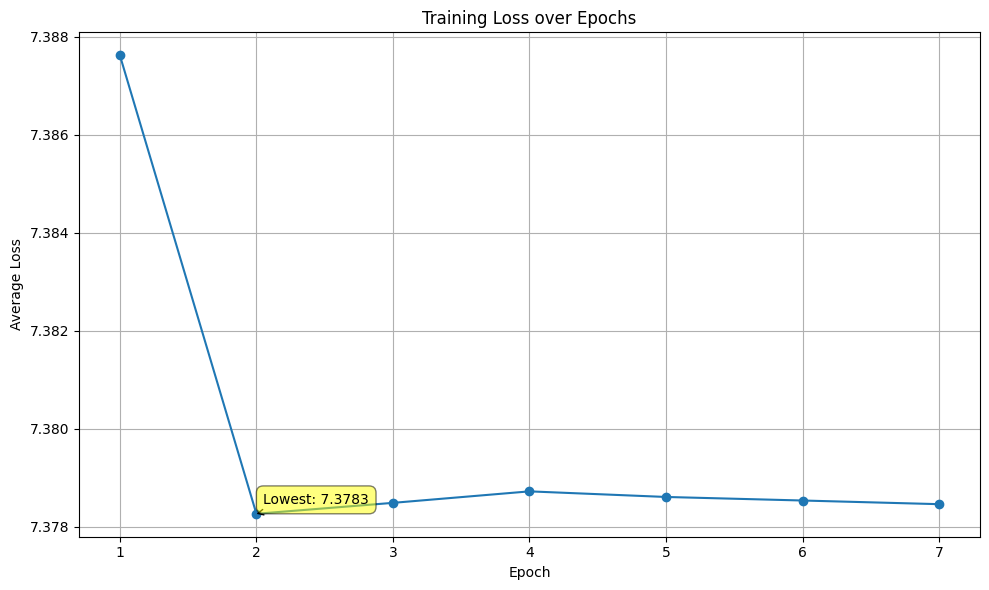

In [36]:
def plot_loss_history(loss_history, num_epochs):
    plt.figure(figsize=(10, 6))
    plt.plot(range(1, num_epochs + 1), loss_history, marker="o")
    plt.title("Training Loss over Epochs")
    plt.xlabel("Epoch")
    plt.ylabel("Average Loss")
    plt.grid(True)
    plt.xticks(range(1, num_epochs + 1))  # Set x-axis ticks to show each epoch

    # Annotate the lowest loss point
    min_loss = min(loss_history)
    min_epoch = loss_history.index(min_loss) + 1
    plt.annotate(
        f"Lowest: {min_loss:.4f}",
        xy=(min_epoch, min_loss),
        xytext=(5, 5),
        textcoords="offset points",
        ha="left",
        va="bottom",
        bbox=dict(boxstyle="round,pad=0.5", fc="yellow", alpha=0.5),
        arrowprops=dict(arrowstyle="->", connectionstyle="arc3,rad=0"),
    )

    plt.tight_layout()
    plt.show()


plot_loss_history(train_loss_history, num_epochs)

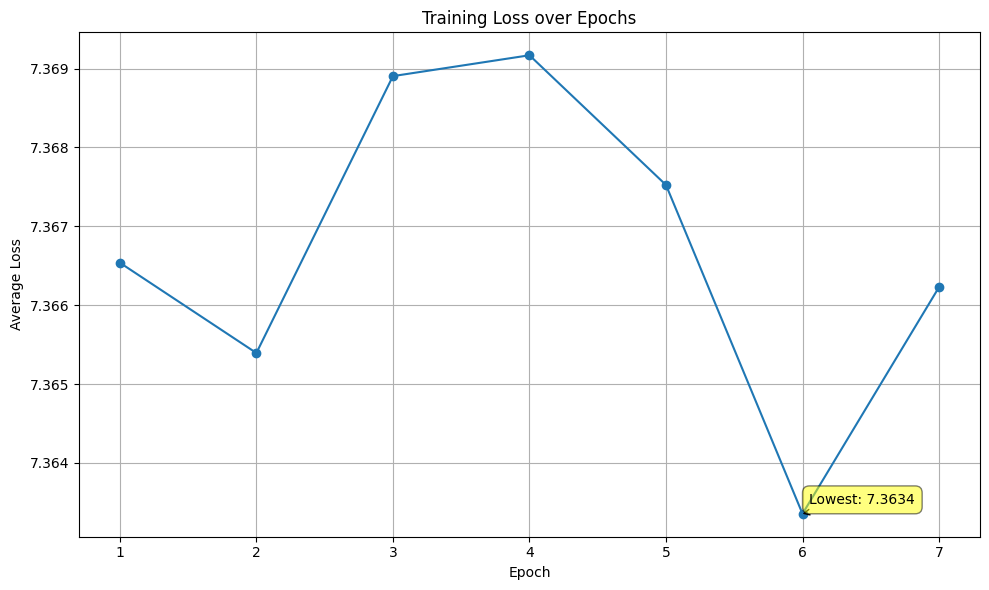

In [37]:
plot_loss_history(val_loss_history, num_epochs)

In [38]:
class TopKAccuracyMetric:
    def __init__(self, k_values: List[int]):
        self.k_values = sorted(k_values)
        self.reset()

    def reset(self):
        self.total = 0
        self.correct = {k: 0 for k in self.k_values}

    def update(self, predictions: torch.Tensor, targets: torch.Tensor):
        # predictions: [batch_size, num_items] tensor of similarity scores
        # targets: [batch_size] tensor of correct item indices

        # Get the top k predictions for each query
        _, top_indices = torch.topk(predictions, max(self.k_values), dim=1)

        # Convert targets to column vector for broadcasting
        targets = targets.view(-1, 1)

        # Check if correct item is in top k predictions
        for k in self.k_values:
            correct_in_k = (top_indices[:, :k] == targets).any(dim=1)
            self.correct[k] += correct_in_k.sum().item()

        self.total += len(targets)

    def compute(self):
        return {f"top_{k}_accuracy": (self.correct[k] / self.total) * 100 for k in self.k_values}

In [39]:
def evaluate_top_k(model: TwoTowerModel, val_loader: DataLoader, k_values: List[int]):
    model.eval()
    metric = TopKAccuracyMetric(k_values)

    # First, compute all item embeddings
    print("Computing item embeddings...")
    all_item_embeddings = []
    all_item_ids = []

    with torch.no_grad():
        for batch in tqdm(unique_items_loader):
            item_embeddings = model.item_tower(batch)
            all_item_embeddings.append(item_embeddings.cpu())
            all_item_ids.extend(batch["article_id"].cpu())

    all_item_embeddings = torch.cat(all_item_embeddings, dim=0).to(device)

    # Create mapping from item_id to index
    item_id_to_idx = {item_id.item(): idx for idx, item_id in enumerate(all_item_ids)}

    print("Computing top-k accuracy...")
    with torch.no_grad():
        for batch in tqdm(val_loader):

            # Get query embeddings
            query_embeddings = model.query_tower(batch)

            # Compute similarity scores with all items
            similarity_scores = torch.matmul(query_embeddings, all_item_embeddings.t())

            item_data = batch["article_id"].astype(int)

            # Get target indices
            a = []
            for item_id in item_data:
                # print(item_id, type(item_id))
                a.append(item_id_to_idx[item_id])

            target_indices = torch.tensor(a).to(device)
            # target_indices = torch.tensor([item_id_to_idx[item_id] for item_id in item_data]).to(device)

            # Update metrics
            metric.update(similarity_scores, target_indices)

    return metric.compute()

In [41]:
top_k = evaluate_top_k(model, val_loader, k_values=[100])
print(top_k)

Computing item embeddings...


100%|██████████| 52/52 [00:01<00:00, 33.32it/s]


Computing top-k accuracy...


100%|██████████| 1546/1546 [15:35<00:00,  1.65it/s]

{'top_100_accuracy': 0.6114748861462957}


In [43]:
top_k["top_100_accuracy"]

0.6114748861462957